In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


df = pd.read_csv('zillow_data.csv.zip')


In [2]:
#here we are filtering out our zipcodes to just look at the top 500 in sizerank
df['Top500'] = df['SizeRank'].apply(lambda x: True if x <= 500 else False)

df = df.loc[df.Top500, :]

#creating growth rate metric and sorting to see top zips
df['GrowthRate'] = df['2018-04'] / df['1996-04'] - 1
df.sort_values('GrowthRate', ascending = False)[:5]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Top500,GrowthRate
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,True,11.189940
475,62027,11216,New York,NY,New York,Kings,476,146100.0,146600.0,147200.0,...,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,True,9.942505
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,True,9.403061
106,62026,11215,New York,NY,New York,Kings,107,225700.0,227500.0,229400.0,...,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900,True,8.941958
258,66125,20001,Washington,DC,Washington,District of Columbia,259,92000.0,92600.0,93200.0,...,771200,773300,777600,780500,781600,785500,791400,793300,True,7.622826


In [3]:
df_nyc = df[df['Metro'] == 'New York']
df_chi = df[df['Metro'] == 'Chicago']
df_la = df[df['Metro'] == 'Los Angeles-Long Beach-Anaheim']
df_dfw = df[df['Metro'] == 'Dallas-Fort Worth']
df_mia = df[df['Metro'] == 'Miami-Fort Lauderdale']

In [4]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    
    return pd.to_datetime(df.columns.values[7:272], format='%Y-%m')

In [5]:
get_datetimes(df_nyc)
get_datetimes(df_la)
get_datetimes(df_mia)
get_datetimes(df_dfw)
get_datetimes(df_chi)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [6]:
#funtion for melting dataframes
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName', 'Top500', 'GrowthRate'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [7]:
df_nyc = melt_data(df_nyc)
df_la = melt_data(df_la)
df_dfw = melt_data(df_dfw)
df_mia = melt_data(df_mia)
df_chi = melt_data(df_chi)

In [8]:
def stationarity_check(df):

    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df['value'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# NYC station

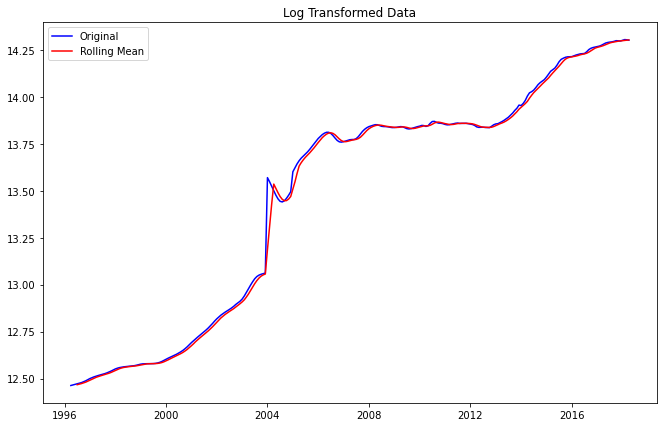

In [9]:
#from the p-value above, we see the data is not stationary. the first approach is to subtract the rolling mean 

# lets create a log transform so we can substract the rolling mean 
roll_mean_nyc = np.log(df_nyc).rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df_nyc), color='blue', label='Original')
plt.plot(roll_mean_nyc, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [10]:
data_minus_roll_mean_nyc = np.log(df_nyc) - roll_mean_nyc

# Print the first 10 rows
data_minus_roll_mean_nyc.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,NaN
1996-07-01,0.004207
1996-08-01,0.004446
1996-09-01,0.005016
1996-10-01,0.005963
1996-11-01,0.007034
1996-12-01,0.008287


In [11]:
data_minus_roll_mean_nyc.dropna(inplace=True)

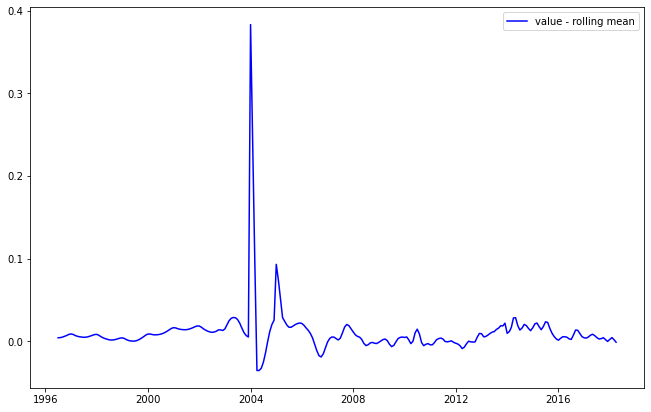

In [12]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean_nyc, color='blue',label='value - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

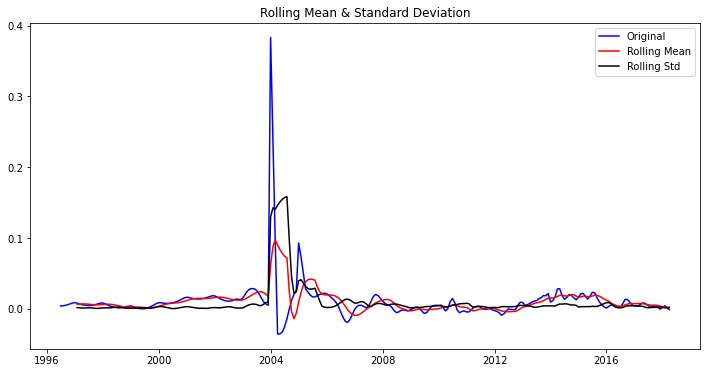

Results of Dickey-Fuller Test: 

Test Statistic                -8.699461e+00
p-value                        3.844340e-14
#Lags Used                     2.000000e+00
Number of Observations Used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


In [13]:
stationarity_check(data_minus_roll_mean_nyc)

In [36]:
model_nyc = data_minus_roll_mean_nyc

# LA station

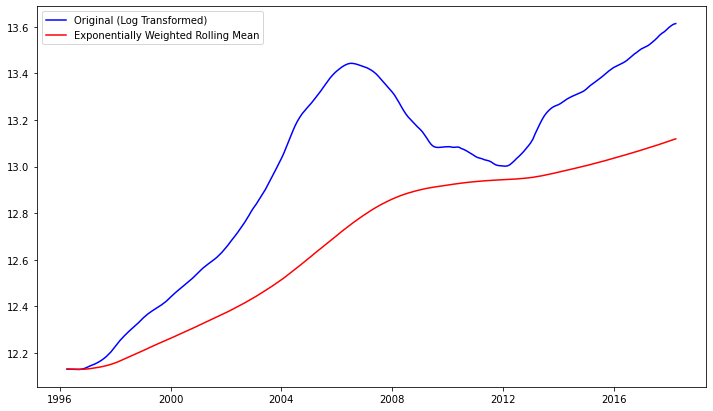

In [16]:
# Calculate Weighted Moving Average of log transformed data, halflife of 12 because it's a year 
#here for final notebook; start with a halflife of 12 --> alpha  of 0.5 --> alpha of 0.05 

exp_roll_mean_la = np.log(df_la).ewm(alpha = .005).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df_la), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean_la, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

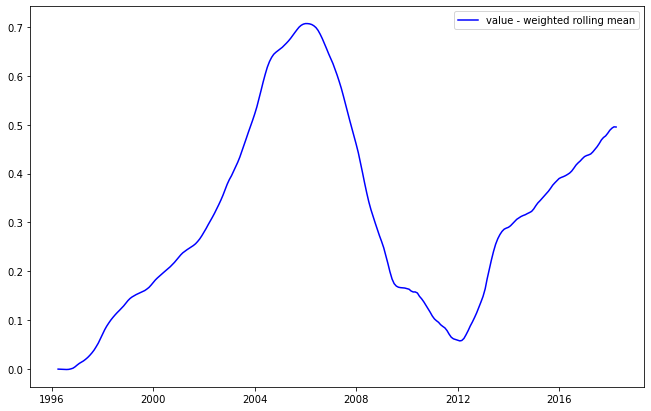

In [17]:
#let's get the difference by  subtracting the exponential rolling mean from the log 
data_minus_exp_roll_mean_la = np.log(df_la) - exp_roll_mean_la

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean_la, color='blue',label='value - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

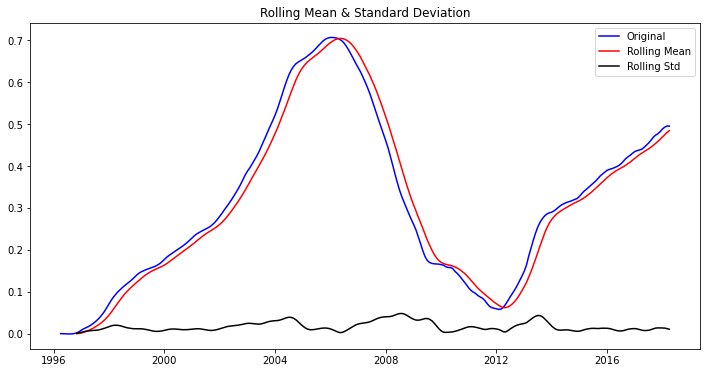

Results of Dickey-Fuller Test: 

Test Statistic                  -2.863459
p-value                          0.049765
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [18]:
stationarity_check(data_minus_exp_roll_mean_la)

In [19]:
la_model = data_minus_exp_roll_mean_la

# DFW station?

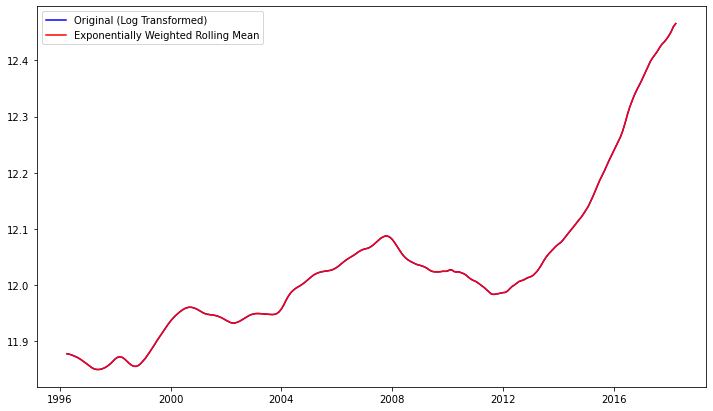

In [20]:
exp_roll_mean_dfw = np.log(df_dfw).ewm(halflife=0.05).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df_dfw), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean_dfw, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

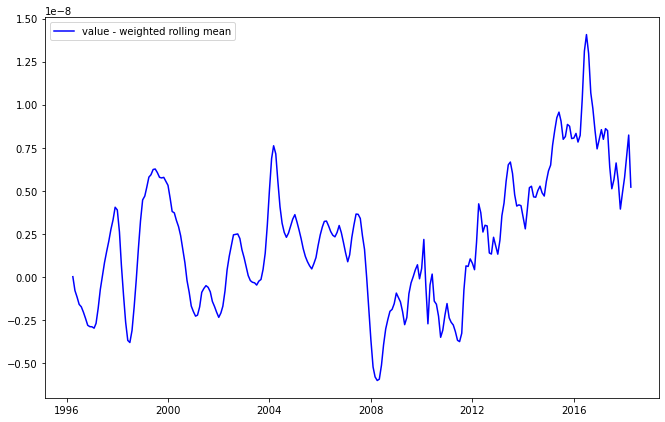

In [21]:
data_minus_exp_roll_mean_dfw = np.log(df_dfw) - exp_roll_mean_dfw

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean_dfw, color='blue',label='value - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

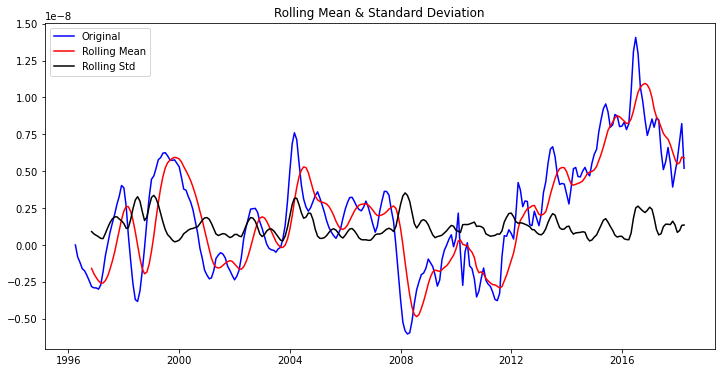

Results of Dickey-Fuller Test: 

Test Statistic                  -2.850358
p-value                          0.051433
#Lags Used                       5.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [22]:
stationarity_check(data_minus_exp_roll_mean_dfw)

In [23]:
dfw_model = data_minus_exp_roll_mean_dfw

# Chicago station

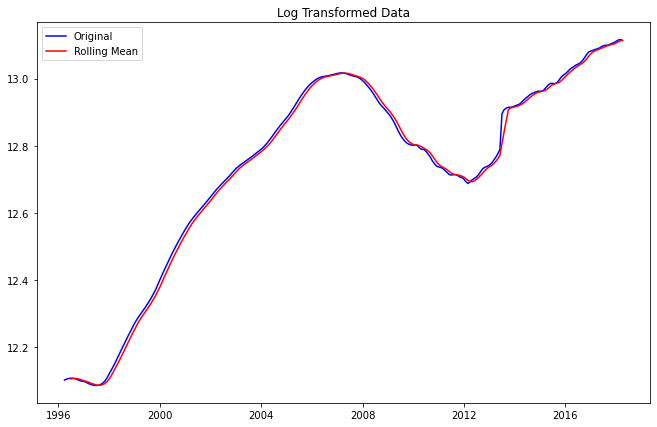

In [24]:
roll_mean_chi = np.log(df_chi).rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df_chi), color='blue', label='Original')
plt.plot(roll_mean_chi, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [26]:
data_minus_roll_mean_chi = np.log(df_chi) - roll_mean_chi

# Print the first 10 rows
data_minus_roll_mean_chi.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,NaN
1996-07-01,0.002266
1996-08-01,0.000654
1996-09-01,-0.000935
1996-10-01,-0.002303
1996-11-01,-0.003645
1996-12-01,-0.003497


In [27]:
data_minus_roll_mean_chi.dropna(inplace=True)

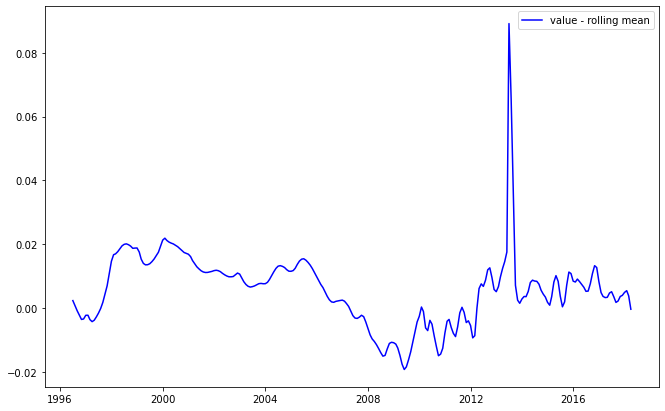

In [28]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean_chi, color='blue',label='value - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

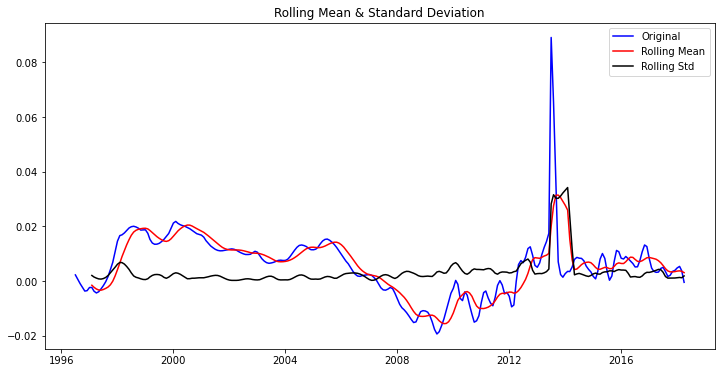

Results of Dickey-Fuller Test: 

Test Statistic                  -3.281159
p-value                          0.015742
#Lags Used                       3.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64


In [29]:
stationarity_check(data_minus_roll_mean_chi)

In [30]:
chi_model = data_minus_roll_mean_chi

# Miami

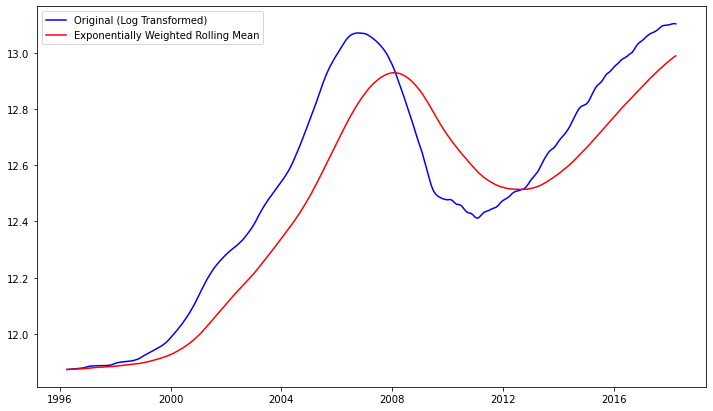

In [31]:
exp_roll_mean_mia = np.log(df_mia).ewm(alpha=0.05).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df_mia), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean_mia, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

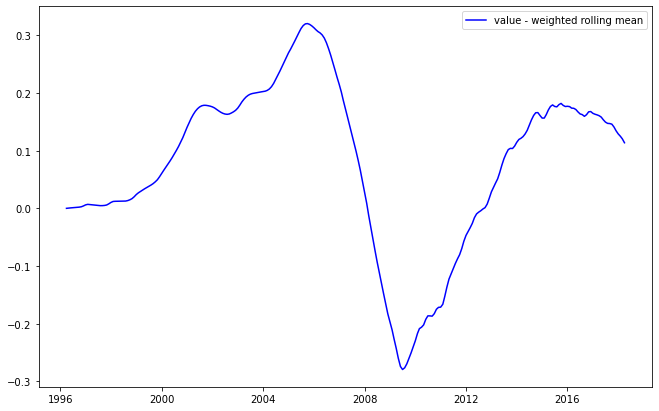

In [32]:
data_minus_exp_roll_mean_mia = np.log(df_mia) - exp_roll_mean_mia

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean_mia, color='blue',label='value - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

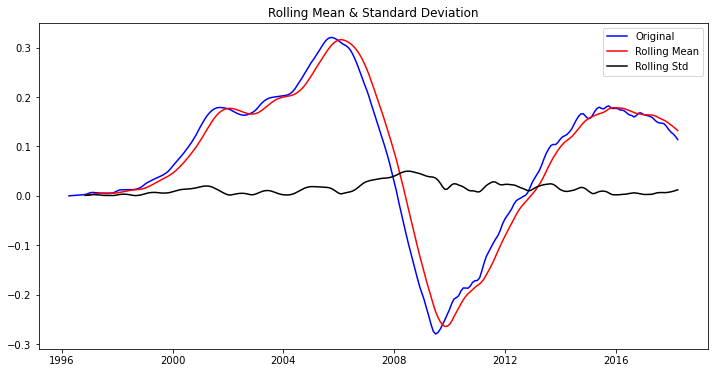

Results of Dickey-Fuller Test: 

Test Statistic                  -3.062570
p-value                          0.029450
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [33]:
stationarity_check(data_minus_exp_roll_mean_mia)

In [34]:
model_mia = data_minus_exp_roll_mean_mia

# Train Test Split time 

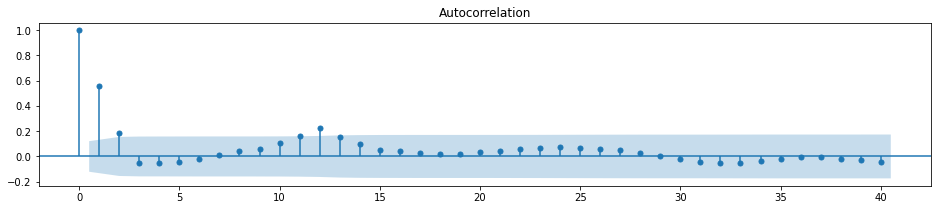

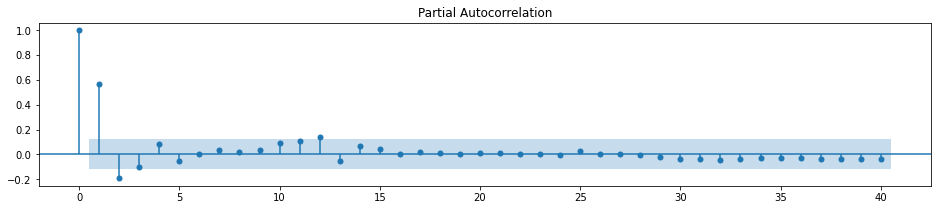

In [37]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_nyc, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_nyc, ax=ax, lags=40);

In [38]:
train = model_nyc.iloc[:-12]
test = model_nyc.iloc[-12:]

In [39]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA(1,0) model
mod_arma = ARIMA(model_nyc, order=(1,0,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  262
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 594.120
Date:                Tue, 25 Oct 2022   AIC                          -1182.240
Time:                        18:27:53   BIC                          -1171.535
Sample:                    07-01-1996   HQIC                         -1177.937
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.012      0.884      0.376      -0.013       0.034
ar.L1          0.5589      0.059      9.536      0.000       0.444       0.674
sigma2         0.0006   1.89e-05     33.149      0.0

In [40]:
#chicago
mod_arma = ARIMA(chi_model, order=(1,0,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  262
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 993.268
Date:                Tue, 25 Oct 2022   AIC                          -1980.536
Time:                        18:28:29   BIC                          -1969.831
Sample:                    07-01-1996   HQIC                         -1976.233
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.006      0.975      0.329      -0.006       0.017
ar.L1          0.8798      0.020     43.588      0.000       0.840       0.919
sigma2      2.962e-05   5.49e-07     53.963      0.0

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


df_nyc = df[df['Metro'] == 'New York']
df_chi = df[df['Metro'] == 'Chicago']
df_la = df[df['Metro'] == 'Los Angeles-Long Beach-Anaheim']
df_dfw = df[df['Metro'] == 'Dallas-Fort Worth']
df_mia = 

In [41]:
mod_arma = ARIMA(la_model, order=(1,0,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 884.762
Date:                Tue, 25 Oct 2022   AIC                          -1763.524
Time:                        18:29:08   BIC                          -1752.785
Sample:                    04-01-1996   HQIC                         -1759.209
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3097      0.079      3.937      0.000       0.156       0.464
ar.L1          0.9962      0.002    488.295      0.000       0.992       1.000
sigma2      7.231e-05      7e-06     10.331      0.0

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [42]:
mod_arma = ARIMA(dfw_model, order=(1,0,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2805.941
Date:                Tue, 25 Oct 2022   AIC                          -5605.881
Time:                        18:29:21   BIC                          -5595.142
Sample:                    04-01-1996   HQIC                         -5601.566
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.118e-09   2.31e-22   9.18e+12      0.000    2.12e-09    2.12e-09
ar.L1          0.9730   1.66e-20   5.85e+19      0.000       0.973       0.973
sigma2          1e-10   1.22e-10      0.821      0.4

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
mod_arma = ARIMA(model_mia, order=(1,0,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 908.551
Date:                Tue, 25 Oct 2022   AIC                          -1811.102
Time:                        18:29:35   BIC                          -1800.363
Sample:                    04-01-1996   HQIC                         -1806.787
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0780      0.174      0.449      0.654      -0.263       0.419
ar.L1          0.9981      0.003    361.923      0.000       0.993       1.003
sigma2      6.026e-05   5.37e-06     11.213      0.0

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
